In [37]:
import csv
import re
import os
import collections
import operator
from email.parser import Parser
import json
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

Email object containing the properties in the JSON file

In [38]:
class email:
    def __init__(self, sender, recipients, body):
        self.sender = sender
        self.recipients = recipients
        self.body = body

In [39]:

"""
# # Reading data from the dataset
"""

emails = []
email_addresses = []

rootdir = "maildirtest"
for directory, subdirectory, filenames in  os.walk(rootdir):
    for filename in filenames:

        #Reading data from file
        with open(os.path.join(directory, filename), "r") as f:
            data = f.read()

        #Creating instance of the email.parser object
        emailParser = Parser().parsestr(data)

        #reading the from section of the email
        sender = emailParser['from']

        #reading the to section of the email, which can contain multiple recipients
        if emailParser['to']:
            recipients = emailParser['to']
            recipients = "".join(recipients.split())
            recipients = recipients.split(",")
        else:
            recipients = ['None']

        if emailParser['cc']:
            cc = emailParser['cc']
            cc = "".join(cc.split())
            cc = cc.split(",")
            recipients.extend(cc)

        if emailParser['bcc']:
            bcc = emailParser['bcc']
            bcc = "".join(bcc.split())
            bcc = bcc.split(",")
            recipients.extend(bcc)

        recipients = list(set(recipients))

        #reading the body section of the email
        body = emailParser.get_payload()

        #Creating an email object and appending it to the list of all emails
        email = Email(sender, recipients, body)
        emails.append(email)

        #Adding all users (email adresses) to a list
        email_addresses.extend(sender)
        email_addresses.extend(recipients)

email_addresses = list(set(email_addresses))

In [41]:
# Creating a dictionary of all the combined documents between two distinct people
dataset = {}
for email in emails:
    for recipient in email.recipients:
        key1 = (email.sender, recipient)
        key2 = (recipient, email.sender)
        
        if(key1 in dataset.keys()):
            dataset[email.sender, recipient] += 1
        elif (key2 in dataset.keys()):
            dataset[recipient, email.sender] += 1
        else:
            dataset[email.sender, recipient] = 1
            
print(dataset)

{('outlook-migration-team@enron.com', 'None'): 2, ('heather.dunton@enron.com', 'k..allen@enron.com'): 3, ('anchordesk_daily@anchordesk.zdlists.com', 'pallen@enron.com'): 2, ('subscriptions@intelligencepress.com', 'pallen@enron.com'): 5, ('prizemachine@feedback.iwon.com', 'pallen@enron.com'): 1, ('louise.kitchen@enron.com', 'scott.neal@enron.com'): 2, ('louise.kitchen@enron.com', 'frank.vickers@enron.com'): 2, ('louise.kitchen@enron.com', 'rita.wynne@enron.com'): 1, ('louise.kitchen@enron.com', 'm.hall@enron.com'): 1, ('louise.kitchen@enron.com', 'mike.curry@enron.com'): 2, ('louise.kitchen@enron.com', 'jenny.rub@enron.com'): 1, ('louise.kitchen@enron.com', 'tim.heizenrader@enron.com'): 1, ('louise.kitchen@enron.com', 'john.arnold@enron.com'): 2, ('louise.kitchen@enron.com', 'lloyd.will@enron.com'): 1, ('louise.kitchen@enron.com', 'fred.lagrasta@enron.com'): 2, ('louise.kitchen@enron.com', 'c..gossett@enron.com'): 1, ('louise.kitchen@enron.com', 'leslie.reeves@enron.com'): 1, ('louise.k

Creating a Directed Graph using the edges found. 
A directed graph entails the nature of the email; ie. the sender and the recipients

In [42]:
G = nx.DiGraph()

for k,v in dataset:
    G.add_edge(k,v, weight=dataset[(k,v)])

In Degree - Getting the number of vertices coming in to the node, from other connected nodes
Out Degree - Getting the number of vertices going out of the node, to other connected nodes

In [43]:
inDegree = G.in_degree()
outDegree = G.out_degree()

Degree Distribution is the probability distribution of the in and out degrees over the whole network

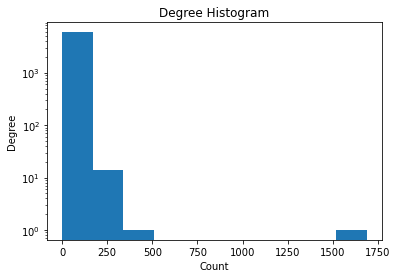

In [44]:
plt.title("Degree Histogram")
plt.xlabel("Count")
plt.ylabel("Degree")

degrees = [G.degree(n) for n in G.nodes()]

plt.hist(degrees, log='true')
plt.show()

Scatter plot of the degree distribution

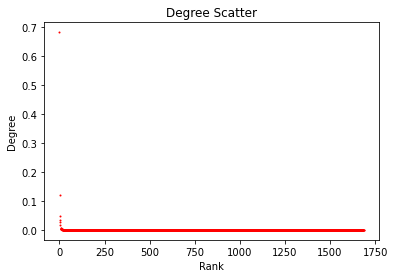

In [45]:
plt.title("Degree Scatter")
plt.xlabel("Rank")
plt.ylabel("Degree")

#creates a distribution of degrees
degree=nx.degree_histogram(G)
degree.sort(reverse=True)

#Generate normalised values for y according to degree
y=[z/float(sum(degree))for z in degree]

#Generate X axis sequence, from 1 to maximum degree
x=range(len(degree))
plt.scatter(x,y,s=1,color=(1,0,0))

plt.show()

The Graph Diameter is the length of the longest shortest path between any two graph vertices.
For arbitrary graphs, we need to compute the shortest path between any two vertices and take the length of the greatest of these paths.
The algorithm starts by calculating the diameter of a graph made of variables and relations. A random node is picked in the tree and a breath first search is used to find the furthest node in the graph.

In [46]:
def Diameter(emails):
    root = random.choice(emails)
    email, distance = find_furthest_node(root, emails)
    _, distance = find_furthest_node(email, emails)
    
    return distance

Creates a subgraph of the largest weakly connected component

In [47]:
largest_cc = max(nx.weakly_connected_components(G), key=len)
SG = G.subgraph(largest_cc)

Average Path Length is the sum of the path lengths between all pairs of nodes normalized by n*(n-1) where n is the number of nodes in the Graph (G).
Since it can only be executed on a connected graph, the AVP has to be calculated on the largest subgraph

In [48]:
#Average Path Length
averagePathLength = nx.average_shortest_path_length(SG)

The Global Clustering Coefficient is the number of closed trianges over the total number of open or closed triplets.
A triplet contain three nodes with 2 edges. A triangle contain three closed overlapping triplets, one centered on each of the nodes

In [49]:
#Global Clustering Coefficient
clusteringCoefficient = nx.average_clustering(G)

Printing Graph Analytics 

In [50]:
print("Average Shortest Path Length: ", averagePathLength, "\n")
print("Clustering Coefficient: ", clusteringCoefficient, "\n")

Average Shortest Path Length:  0.26289376480448573 

Clustering Coefficient:  0.08096911288642626 



Sorting the Dictionary according to value in descending order

In [51]:
def sortDiscDesc(d):
    sorted_d = dict(sorted(d.items(), key=operator.itemgetter(1), reverse = True))
    return sorted_d

Betweenness Centrality of a node is the sum of the fraction of all pairs shortest paths that pass through the node in question

In [55]:
#Betweeness Centrality
betweennessCentrality = nx.betweenness_centrality(G, normalized=True)
betweennessCentrality = sortDiscDesc(betweennessCentrality)

print(betweennessCentrality)

{'kenneth.lay@enron.com': 0.050973114250108226, 'rosalee.fleming@enron.com': 0.02389390695646683, 'alyse.herasimchuk@enron.com': 0.01282352767097249, 'billy.lemmons@enron.com': 0.006689824755476972, 'ken.rice@enron.com': 0.005166319302639639, 'louise.kitchen@enron.com': 0.004643717142322557, 'sanjay.bhatnagar@enron.com': 0.0043909975248053595, 'rebecca.mcdonald@enron.com': 0.00415479451975709, 'phillip.allen@enron.com': 0.003945508246452344, 'connie.blackwood@enron.com': 0.0036930177046327873, 'david.oxley@enron.com': 0.003573488661259889, 'bill.gathmann@enron.com': 0.0034649277841253268, 'k..allen@enron.com': 0.003338555021298798, 'ajones@uwtgc.org': 0.002859668956256765, 'jjiles@bear.com': 0.0027083706791366487, 'karen.denne@enron.com': 0.0023999912406737775, 'joannie.williamson@enron.com': 0.00239359289897514, 'robyn@layfam.com': 0.002138542684970938, 'ceoextra@houston.org': 0.0017922617274578369, 'mschopper@houston.org': 0.00167740111730038, 'j..kean@enron.com': 0.00159634956958755

Page Rank determines the popularity of a node in the whole dataset, implying how important the node is in the dataset. Therefore, this implies the more active senders and receivers of emails in the dataset

In [56]:
#Page Rank
pr = nx.pagerank(G, 0.4)
print(pr)

{'outlook-migration-team@enron.com': 0.00015325568996893123, 'None': 0.004443650977167113, 'heather.dunton@enron.com': 0.00015397529173478627, 'k..allen@enron.com': 0.0012781297818034898, 'anchordesk_daily@anchordesk.zdlists.com': 0.00015325568996893123, 'pallen@enron.com': 0.0012788617016673668, 'subscriptions@intelligencepress.com': 0.00015325568996893123, 'prizemachine@feedback.iwon.com': 0.00015325568996893123, 'louise.kitchen@enron.com': 0.0002180959571137321, 'scott.neal@enron.com': 0.0002102961562911575, 'frank.vickers@enron.com': 0.00015579883915161087, 'rita.wynne@enron.com': 0.00016639204371417775, 'm.hall@enron.com': 0.00015566396967220254, 'mike.curry@enron.com': 0.00016766361830551757, 'jenny.rub@enron.com': 0.0001927097216540333, 'tim.heizenrader@enron.com': 0.00018208657089346982, 'john.arnold@enron.com': 0.00016813105671018984, 'lloyd.will@enron.com': 0.00017744613762276135, 'fred.lagrasta@enron.com': 0.00016952323316181628, 'c..gossett@enron.com': 0.0001896098124834662

Force Directed Graph using NetworkX on the JSON File

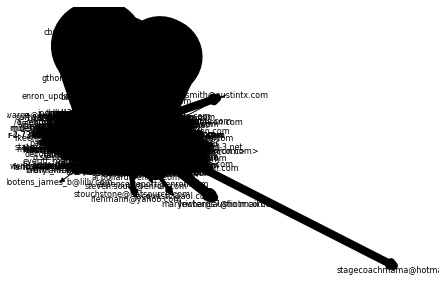

In [66]:
weights = [G[u][v]['weight'] for u,v in dataset]

node_sizes = []
for n in SG.nodes():
    node_sizes.append(betweennessCentrality[n])

nx.draw_kamada_kawai(SG, node_size=node_sizes, with_labels=True, font_size=8, width=weights)
plt.show()